# Classification

### Libraries

In [102]:
import numpy as np

# Sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

# Viz
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Utilities

In [2]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

### Data

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
type(mnist), mnist.keys()

(sklearn.utils.Bunch,
 dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url']))

In [5]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [6]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
X.shape, y.shape

((70000, 784), (70000,))

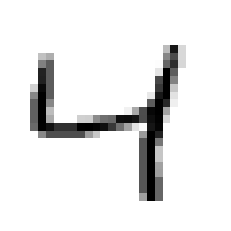

In [8]:
some_digit = X[2]
plot_digit(some_digit)

In [9]:
y[2]

'4'

Test Train Split

In [10]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

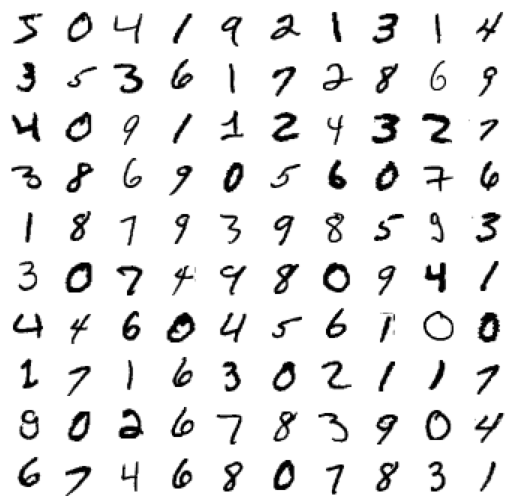

In [11]:
plt.figure(figsize=(9,9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)

Training a Binary Classifier

In [12]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([False])

Performance Measures

Measuring Accuracy Using Cross-Validation


In [15]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Custom Cross-Validation Implementation

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    # Clone constructs a new unfitted estimator with the same parameters.
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    X_test_fold = X_train[test_idx]
    y_test_fold = y_train_5[test_idx]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


Confusion Matrices

In [19]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
len(y_train_pred)

60000

In [21]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [22]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

Precision and 

$Precision = \frac{TP}{TP + FP}$

$Recall (True Positive Rate) = \frac{TP}{TP + FN}$

In [23]:
precision_score(y_train_5, y_train_pred) # If a 5, 83.7% correct.

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred) # Only detects 65.1% of the 5s.

0.6511713705958311

$F_{1} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The Precision/Recall Trade-off

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-13489.14805779])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [29]:
threshold = 3000

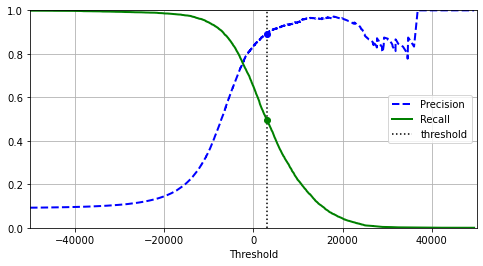

In [30]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

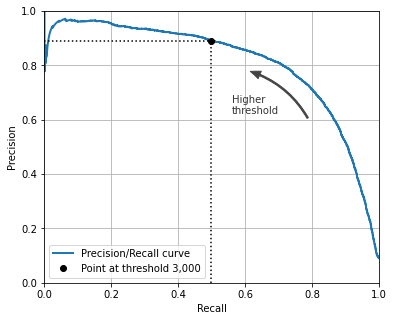

In [31]:
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))

plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

Receiver Operating Characteristic (ROC) Curve <br>
Plots the true positive rate (recall) against the false positive rate (fall out).

In [37]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

NumPy array's argmax returns the first index of the maximum value.

In [38]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
tpr_90, fpr_90

(0.4799852425751706, 0.005295076861063779)

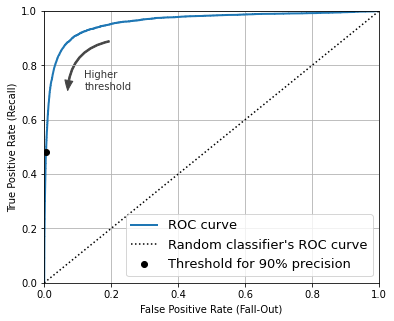

In [39]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

ROC AUC (area under the curve)

In [40]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Comparing RandomForestClassifier and SGDClassifier

In [41]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


In [42]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [43]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

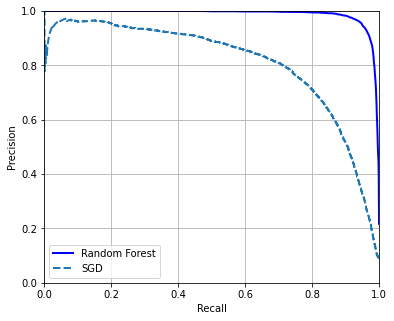

In [44]:
# PR Curves comparisons
plt.figure(figsize=(6,5))
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, '--', linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

RandomForestClassifier's PR curve is much closer to the top right corner.

In [45]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

Multiclass Classification

In [46]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])

array(['4'], dtype=object)

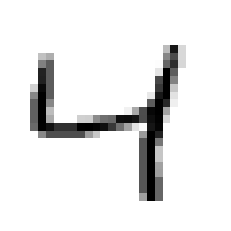

In [47]:
plot_digit(some_digit)

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 1.76, -0.29,  7.23,  1.89,  9.3 ,  4.94,  3.84,  6.1 ,  1.75,
         8.19]])

In [49]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [50]:
# Sklearn's multiclass options.
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [51]:
ovr_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [52]:
len(ovr_clf.estimators_)

10

In [53]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [57]:
# More robust accuracy evaluation.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

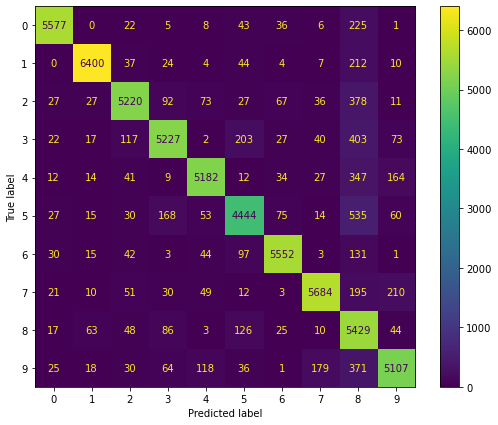

In [68]:
_, ax = plt.subplots(figsize=(9,7))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax)
plt.show()

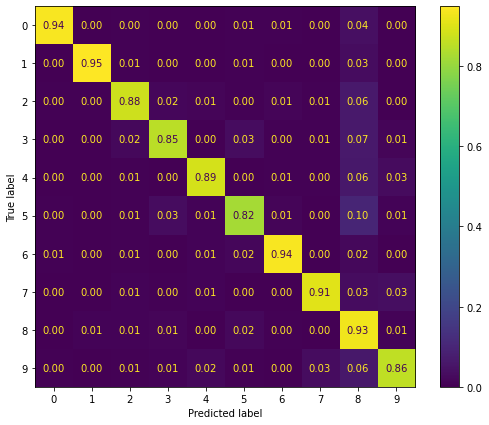

In [77]:
_, ax = plt.subplots(figsize=(9,7))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".2f", ax=ax)
plt.show()

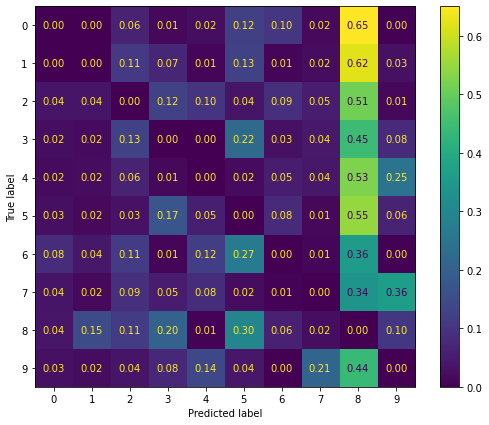

In [81]:
_, ax = plt.subplots(figsize=(9,7))
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,sample_weight=sample_weight, normalize="true", values_format=".2f", ax=ax)
plt.show()

In [82]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

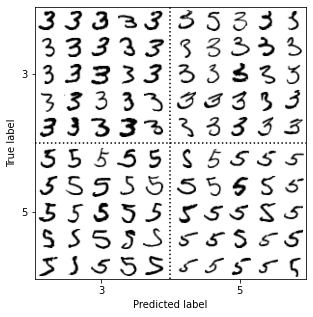

In [86]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
        
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])

plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Multilabel Classification

In [88]:
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [90]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [91]:
knn_clf.predict([some_digit])

array([[False, False]])

(None, array([[False,  True]]))

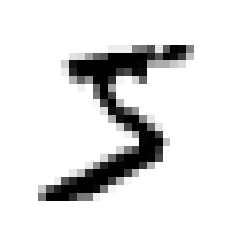

In [99]:
plot_digit(X_train[0]), knn_clf.predict([X_train[0]])

In [100]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

In [101]:
# Weighted f1_score.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [103]:
# Classifier Chain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [104]:
chain_clf.predict([some_digit])

array([[0., 0.]])

In [105]:
chain_clf.predict([X_train[0]])

array([[0., 1.]])

### Multioutput Classification
Add noise to MNIST images, then use original MNIST images without noise as labels.

In [106]:
# Creating training test.
np.random.seed(42)
noise = np.random.randint(0, 100,(len(X_train), 784))

In [110]:
noise[0].shape, X_train[0].shape

((784,), (784,))

In [111]:
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

In [115]:
np.random.randint(0, 100, (5, 7))

array([[52, 47, 47, 45, 46,  1, 25],
       [32, 92, 63, 85,  6, 37, 36],
       [93, 48, 48,  5, 70, 86, 87],
       [87, 23, 38, 34, 91,  2, 76],
       [67,  0,  1, 12, 18, 15, 92]])

In [116]:
# The original images are now the labels.
y_train_mod = X_train
y_test_mod = X_test

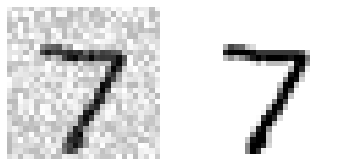

In [118]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

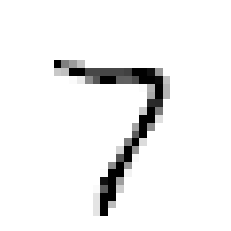

In [119]:
# Training a classifier to go from left to right above.
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()